In [406]:
# 필요한 라이브러리
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

- `pip install -r requirements.txt` 를 이용해 필요한 모듈 설치
- `pytesseract` 는 추가로 [여기]()에서 다운로드 진행해야됨 

테스트용 이미지 가져오기

In [407]:
img_path = './car_img/car2.jpg'
image = cv2.imread(img_path)

이미지 노이즈를 줄이기 위해 가우시안 필터 적용: `blur_img`

In [408]:
blur_img = cv2.GaussianBlur(image, (5, 5), sigmaX=0)

**Thresholding** 을 하기 위해 흑백 이미지로 변환해준다

이미지 전처리 비교하기 위해서 
- 기존 이미지 -> 흑백: `gray_img`
- 가우시안 블러 -> 흑백: `blur_img`

In [409]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY) 


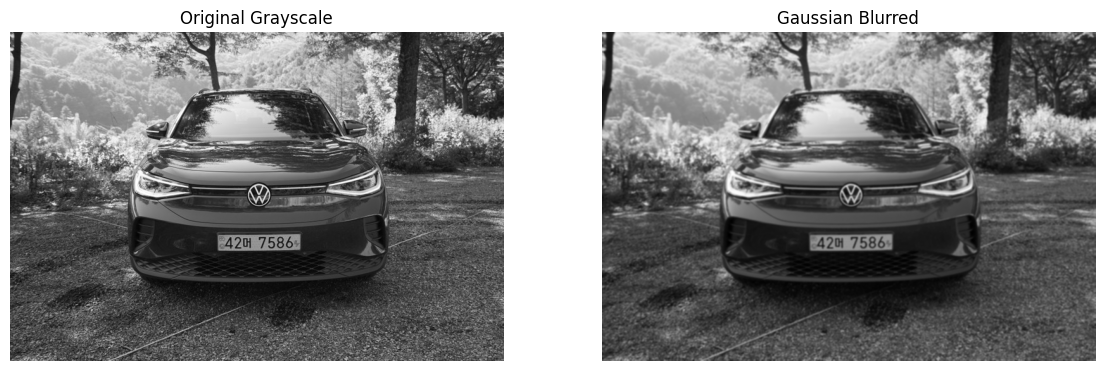

In [410]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blur_img, cmap='gray')
plt.title('Gaussian Blurred')
plt.axis('off')
plt.show()

**Thresholding** 처리 후 이미지 비교

In [411]:
_, thresh_gray_img = cv2.threshold(gray_img, 120, 255, cv2.THRESH_BINARY)
_, thresh_blur_img = cv2.threshold(blur_img, 120, 255, cv2.THRESH_BINARY)

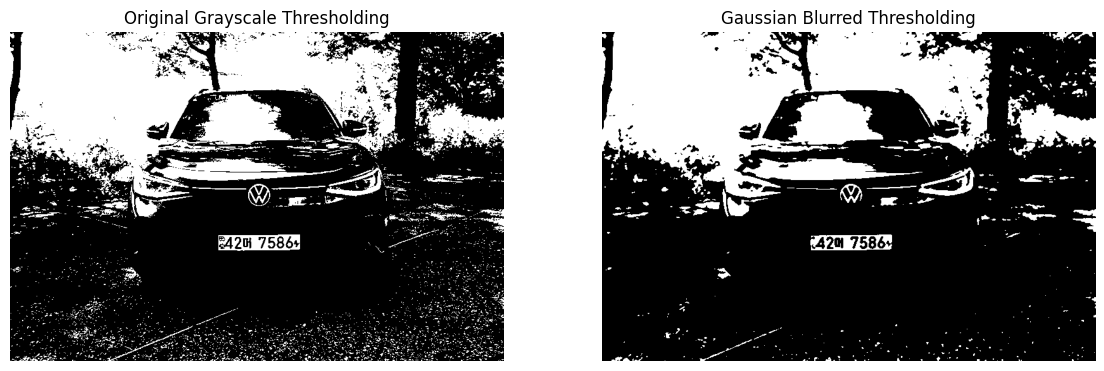

In [412]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(thresh_gray_img, cmap='gray')
plt.title('Original Grayscale Thresholding')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh_blur_img, cmap='gray')
plt.title('Gaussian Blurred Thresholding')
plt.axis('off')
plt.show()

이미지 윤곽선 찾기 (Counour)

In [413]:
contours_gray, hierarchy = cv2.findContours(thresh_gray_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours_blur, hierarchy = cv2.findContours(thresh_blur_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [414]:
# 윤곽선 그릴 캔버스
temp_result_gray = np.zeros(image.shape, dtype=np.uint8)
temp_result_blur = np.zeros(image.shape, dtype=np.uint8)

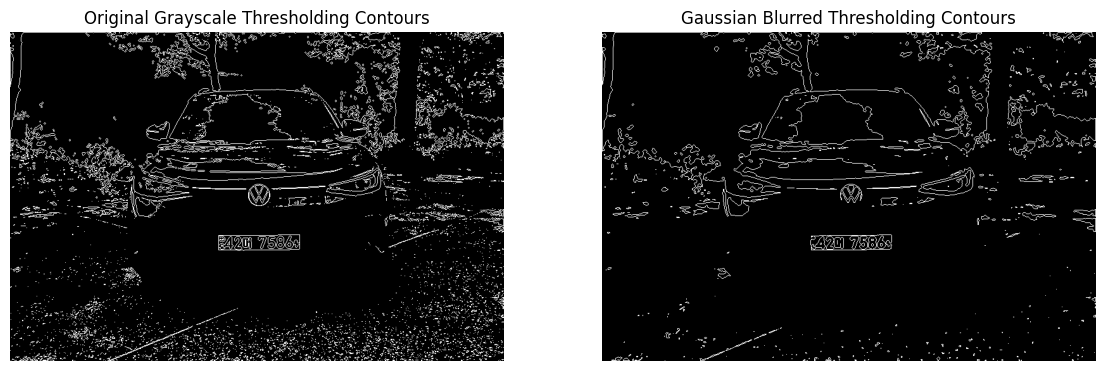

In [415]:
# 윤곽선 그리기
cv2.drawContours(temp_result_gray, contours_gray, contourIdx=-1, color=(255,255,255))
cv2.drawContours(temp_result_blur, contours_blur, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(temp_result_gray, cmap='gray')
plt.title('Original Grayscale Thresholding Contours')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(temp_result_blur, cmap='gray')
plt.title('Gaussian Blurred Thresholding Contours')
plt.axis('off')
plt.show()

전처리를 하지 않은 사진은 모든 엣지가 그려진 결과가 나타난 반면, 가우시안 블러 처리를 한 이미지에서 노이즈가 적은 것을 확인할 수 있다.

In [416]:
# contours box 저장 함수
def draw_contours(contours):
    contours_dict = []
    # 검출된 영역 저장
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        contours_dict.append({
            'contour':contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (h / 2), # 가로 길이
            'cy': y + (h / 2), # 세로 길이
        })
    print(f"[DEBUG]검출된 영역 저장: {len(contours_dict)}개")    
    return contours_dict

In [417]:
# 윤곽선 BOX 그릴 캔버스
temp_result_gray = np.zeros(image.shape, dtype=np.uint8)
temp_result_blur = np.zeros(image.shape, dtype=np.uint8)

[DEBUG]검출된 영역 저장: 3973개
[DEBUG]검출된 영역 저장: 539개


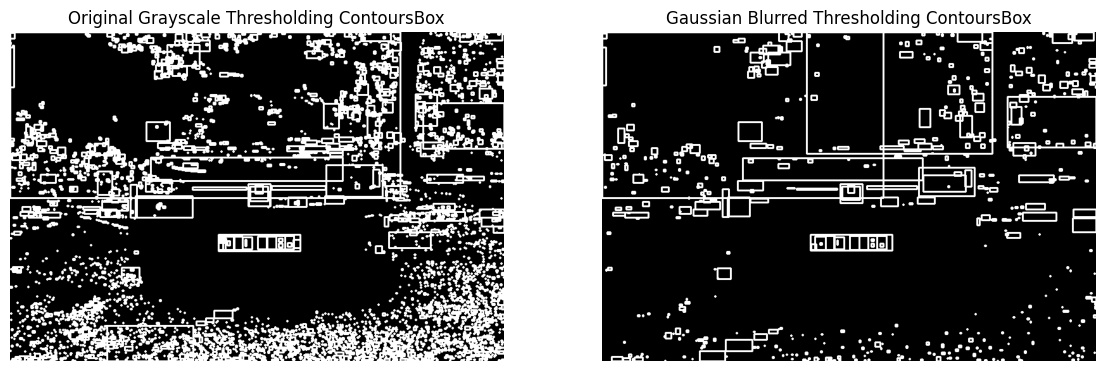

In [418]:
contours_dict_gary = draw_contours(contours_gray)
contours_dict_blur =draw_contours(contours_blur)

for c in contours_dict_gary:
    cv2.rectangle(temp_result_gray, pt1=(c['x'], c['y']), pt2=(c['x']+c['w'], c['y']+c['h']), color=(255, 255, 255), thickness=2)

for c in contours_dict_blur:
    cv2.rectangle(temp_result_blur, pt1=(c['x'], c['y']), pt2=(c['x']+c['w'], c['y']+c['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(temp_result_gray, cmap='gray')
plt.title('Original Grayscale Thresholding ContoursBox')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(temp_result_blur, cmap='gray')
plt.title('Gaussian Blurred Thresholding ContoursBox')
plt.axis('off')
plt.show()


차량 번호판 특성상 크기, 비율이 비슷하다는 점을 이용해 필터링 해주었다.

In [419]:
# box 크기에 따른 필터링된 contourBox 저장 함수
def find_possible_contours(contours_dict):
    # 이건 나중에 옵션으로 줄까?
    MIN_AREA, MIN_WIDTH, MIN_HEIGHT = 80, 2, 8
    MIN_RATIO, MAX_RATIO = 0.25, 1.0

    possible_contours = []
    cnt = 0
    for c in contours_dict:
        area = c['w'] * c['h']
        ratio = c['w'] / c['h']

        if area > MIN_AREA and c['w'] > MIN_WIDTH and c['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
            c['idx'] = cnt
            cnt += 1
            possible_contours.append(c)

    print(f"[DEBUG]영역 크기로 필터링된 contours: {len(possible_contours)}개")    
    return possible_contours

[DEBUG]영역 크기로 필터링된 contours: 25개
[DEBUG]영역 크기로 필터링된 contours: 16개


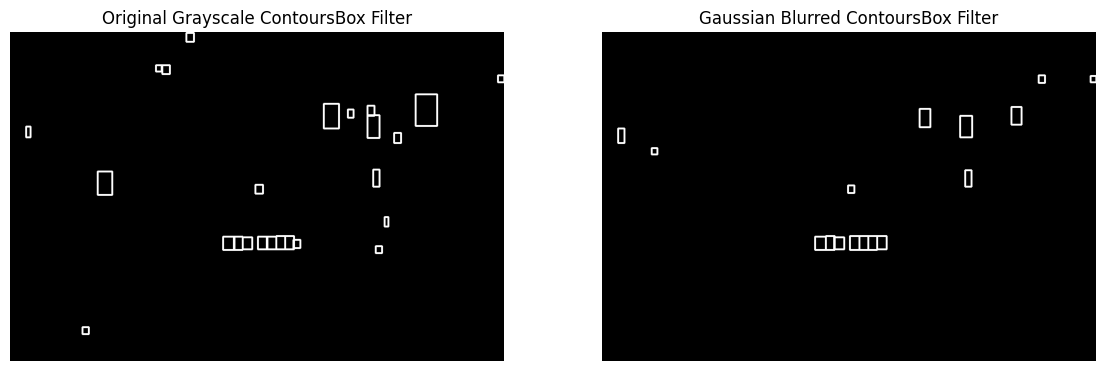

In [420]:

possible_contours_gray = find_possible_contours(contours_dict_gary)
temp_result_gray = np.zeros(image.shape, dtype = np.uint8)

for c in possible_contours_gray:
    cv2.rectangle(temp_result_gray, pt1=(c['x'], c['y']), pt2=(c['x']+c['w'], c['y']+c['h']), color=(255, 255, 255), thickness=2)

possible_contours_blur = find_possible_contours(contours_dict_blur)
temp_result_blur = np.zeros(image.shape, dtype = np.uint8)

for c in possible_contours_blur:
    cv2.rectangle(temp_result_blur, pt1=(c['x'], c['y']), pt2=(c['x']+c['w'], c['y']+c['h']), color=(255, 255, 255), thickness=2)

# 그리기
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(temp_result_gray, cmap='gray')
plt.title('Original Grayscale ContoursBox Filter')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(temp_result_blur, cmap='gray')
plt.title('Gaussian Blurred ContoursBox Filter')
plt.axis('off')
plt.show()

차량 번호판 특성상 다음과 같은 특징이 있다.
- 번호의 간격이 일정함
- 4개 이상 contour 가 붙어있음
- 연속된 contour 의 비율은 모두 비슷할 것

In [421]:
def find_chars(contour_list):
    MAX_DIAG_MULTIPLYER = 4
    MAX_ANGLE_DIFF = 12.0
    MAX_AREA_DIFF = 0.4
    MAX_WIDTH_DIFF = 0.6
    MAX_HEIGHT_DIFF = 0.2
    MIN_N_MATCHED = 4

    matched_result_idx = []

    for c1  in contour_list:
        matched_contours_idx = []
        for c2 in contour_list:
            if c1['idx'] == c2['idx']: # 같은 contour 비교시 continue
                continue;

            dx = abs(c1['cx'] - c2['cx'])
            dy = abs(c1['cy'] - c2['cy'])

            diagonal_length = np.sqrt(c1['w'] ** 2 + c1['h'] ** 2)

            distance = np.linalg.norm(np.array([c1['cx'], c1['cy']]) - np.array([c2['cx'], c2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(c1['w'] * c1['h'] - c2['w'] * c2['h']) / (c1['w'] * c1['h'])
            width_diff = abs(c1['w'] - c2['w']) / c1['w']
            height_diff = abs(c1['h'] - c2['h']) / c1['h']
        
            if distance < diagonal_length * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(c2['idx'])
                
        matched_contours_idx.append(c1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours_blur, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

In [422]:
result_idx = find_chars(possible_contours_blur)

In [423]:
result_idx

[[1, 2, 3, 4, 5, 6, 0]]

In [424]:
matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours_blur, idx_list))
    
temp_result = np.zeros(image.shape, dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

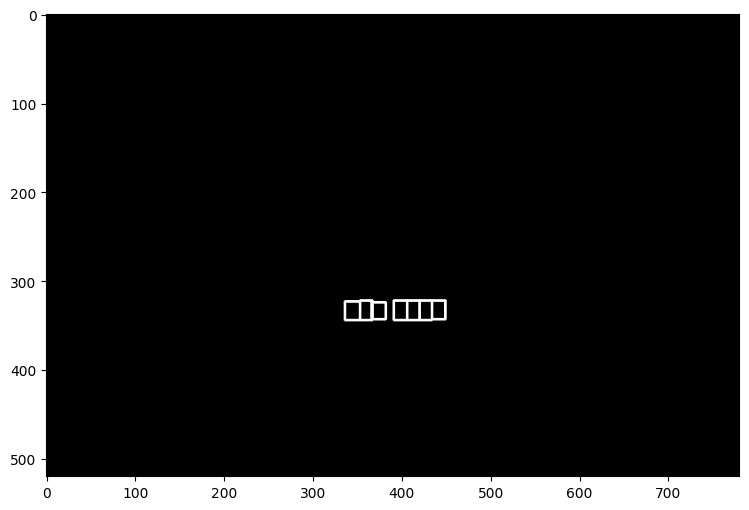

In [425]:
plt.figure(figsize=(10, 6))  # 가로: 10인치, 세로: 5인치 → 가로로 넓은 형태
plt.imshow(temp_result, cmap='gray')

In [426]:
print(len(matched_result[0]))
for group in matched_result:
    x_min = min([d['x'] for d in group])
    y_min = min([d['y'] for d in group])
    x_max = max([d['x'] + d['w'] for d in group])
    y_max = max([d['y'] + d['h'] for d in group])

    # 번호판 전체 박스 그리기
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plate_region = image[y_min:y_max, x_min:x_max]

7


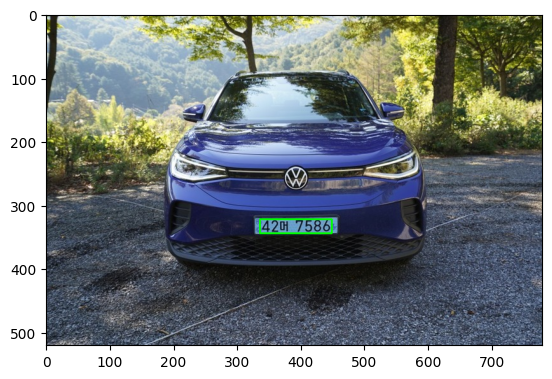

In [427]:
# OpenCV는 BGR, Matplotlib는 RGB 이기 때문에 색 변환이 필요하다
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

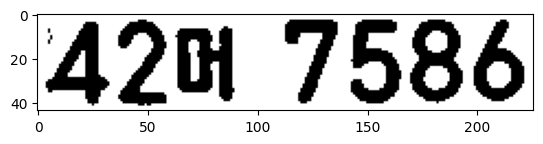

In [428]:
# plt.imshow(cv2.cvtColor(plate_region, cv2.COLOR_BGR2RGB))
# 기존 번호판을 인식 할 때 사용했던  threshold 에서 이미지를 떼어오는 것 보다 
# 추출된 영역에서 다시 설정해주는 것이 좋다.
# gray_plate = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)
# _, thresh_plate = cv2.threshold(gray_plate, 117, 255, cv2.THRESH_BINARY)

gray = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)  # 확대
blur = cv2.GaussianBlur(gray, (3, 3), 0)  # 노이즈 제거
_, thresh = cv2.threshold(blur, 121, 255, cv2.THRESH_BINARY)  # 이진화


plt.imshow(thresh, cmap='gray')


In [429]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Dev\Tool\Tesseract-OCR\tesseract.exe"
chars = pytesseract.image_to_string(thresh, lang='kor', config='--psm 7 --oem 0')

In [430]:
chars.strip()

'42머 7586'